# Case study: Algorithmic trading
## Financial Data Analytics in Python
### Onur Akin **Sir**
#### 222221335
akin.sir@student.uni-halle.de <br>
https://onurakinsir.com

In [152]:
# This code to expand the width of Jupyter Notebook cells
from IPython.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

In [3]:
# Installing the essential libraries
import requests
import pandas as pd
from pandas import json_normalize
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta
import time
from sqlalchemy import create_engine
import math 
from time import sleep

In [ ]:
# Connecting to API
ClientID = "PLEASE INDICATE YOUR ClientID HERE"
ClientSecret = "PLEASE INDICATE YOUR ClientSecret HERE"
response = requests.get("https://test.deribit.com/api/v2/public/auth?client_id="+ClientID+"&client_secret="+
                        ClientSecret+"&grant_type=client_credentials")

response_json = response.json()

response_json["result"]

In [155]:
# Introducing the essential functions
url = "https://test.deribit.com/api/v2/"
instrument_2 = "ETH-PERPETUAL"
instrument_1 = "BTC-PERPETUAL"
# actions will save the trading history
actions = [] 

# Class connects the database, and has several functions:
    # Downloand and save,
    # Select and return
    # Display data as a plot (e.g. last price over time)
class DataHandler:
    def __init__(self, instrument_name):
        self.instrument_name = instrument_name
        self.engine = engine = create_engine(f"sqlite:///{instrument_name}_dt.db")
        self.url = "https://www.deribit.com/api/v2/public/get_tradingview_chart_data"
        
    def download(self):
        msg = {
                "jsonrpc" : "2.0",
                "id" : 833,
                "method" : "public/get_tradingview_chart_data",
                "params" : {
                "instrument_name" : self.instrument_name,
                "end_timestamp": int(time.time() * 1000),  # In Epoch milliseconds
                "start_timestamp": int((time.time() - 1e6) * 1000), # In Epoch milliseconds
                "resolution" : "1"  # minute data
                }
            }
        response = requests.post(url, json=msg)
        data = response.json()
        fi = pd.DataFrame(data['result']) # fi stands for (F)inancial (I)nstrument
        fi['timestamp'] = pd.to_datetime(fi['ticks'], unit='ms')
        fi['instrument_name'] = self.instrument_name
        fi['resolution'] = 1
        fi.drop(columns=["ticks", "status"], inplace = True)
        fi["logreturns"] = np.log(fi["close"] / fi["close"].shift(1))
        fi.to_sql('fi', self.engine, if_exists='replace')
        
        
    def select(self, query):
        return pd.read_sql(query, self.engine)
    
    def plot(self, query):
        df = self.select(query)
        df.plot()
        plt.title(f"{query}")
        plt.show()
    
# function works for selling the x amount of instrument
def sell_amount(instrument_name, selling_amount):
    url = "https://test.deribit.com/api/v2/private/sell"
    params = {
    "amount": selling_amount,
    "instrument_name": instrument_name,
    "type": "market"
    }
    # Sending the GET request
    response = requests.get(url, params=params, auth=(ClientID, ClientSecret))
    response_json = response.json()
    response_json['result']
    
    actions.append({
        'Action': 'Sell',
        'Instrument': instrument_name,
        'Amount': selling_amount,
        'Timestamp': datetime.now(),
        'Price': P_0
    })
    print(f"{selling_amount} {instrument_name} were sold for ${P_0}.")

    # function works for buying the x amount of instrument
def buy_amount(instrument_name, buying_amount):
    # Defining the URL of the endpoint 
    url = "https://test.deribit.com/api/v2/private/buy"
    params = {
        "amount": buying_amount,
        "instrument_name": instrument_name,
        "type": "market"
    }
    response = requests.get(url, params=params, auth=(ClientID, ClientSecret))
    if response.status_code == 200:
        response_json = response.json()
        response_json['result']
    else:
        print(f"Failed to retrieve data: {response.status_code}")
    # also saving the action on the actions list
    actions.append({
        'Action': 'Buy',
        'Instrument': instrument_name,
        'Amount': buying_amount,
        'Timestamp': datetime.now(),
        'Price': P_0
    })
    print(f"{buying_amount} {instrument_name} were purchased for ${P_0}.")
    
def close_position(instrument_name, amount):
    params = {
    "amount": amount,
    "instrument_name": instrument_name,
    "type": "stop_limit",
    "advanced":"usd",
    "price": int(round((1 - 0.45) * P_1,-1)),
    "trigger_price": int(round((1 - 0.5) * P_1,-1)),
    "time_in_force":"good_til_day",
    "trigger":"mark_price"
    }
    actions.append({
        'Action': 'Sell',
        'Instrument': instrument_name,
        'Amount': buying_amount,
        'Timestamp': datetime.now(),
        'Price': P_0
    })
    
    response = requests.get(url, params=params, auth=(ClientID, ClientSecret))
    response_json = response.json()
    response_json['result']
    print(f"{amount} {instrument_name} were purchased for ${P_0} and position was closed! Because the price drops below 50% of the current price.")
    

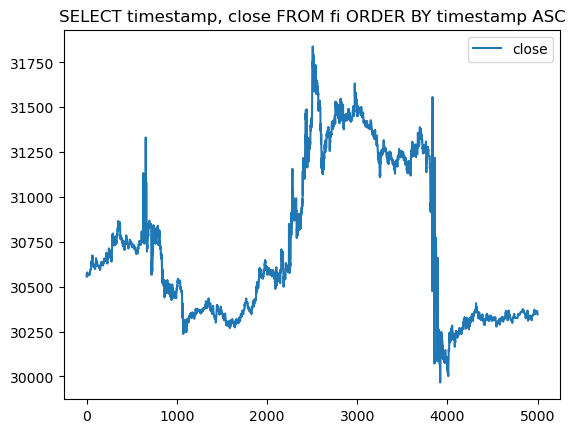

0       30566.5
1       30556.5
2       30557.0
3       30556.5
4       30577.0
         ...   
4996    30364.0
4997    30364.0
4998    30353.5
4999    30346.5
5000    30346.0
Name: close, Length: 5001, dtype: float64


,index,volume,open,low,high,cost,close,timestamp,instrument_name,resolution,logreturns
0,0,1.421256,30564.0,30563.5,30566.5,43440.0,30566.5,2023-07-12 01:44:00.000000,BTC-PERPETUAL,1,NaN
1,1,12.564774,30567.0,30556.5,30567.0,384020.0,30556.5,2023-07-12 01:45:00.000000,BTC-PERPETUAL,1,-0.000327
2,2,0.061525,30556.5,30556.5,30557.0,1880.0,30557.0,2023-07-12 01:46:00.000000,BTC-PERPETUAL,1,0.000016
3,3,0.010472,30556.5,30556.5,30557.0,320.0,30556.5,2023-07-12 01:47:00.000000,BTC-PERPETUAL,1,-0.000016
4,4,9.377456,30556.5,30556.5,30577.0,286610.0,30577.0,2023-07-12 01:48:00.000000,BTC-PERPETUAL,1,0.000671
...,...,...,...,...,...,...,...,...,...,...,...
4996,4996,0.062903,30364.0,30364.0,30364.0,1910.0,30364.0,2023-07-15 13:00:00.000000,BTC-PERPETUAL,1,-0.000016
4997,4997,16.782374,30364.0,30364.0,30364.0,509580.0,30364.0,2023-07-15 13:01:00.000000,BTC-PERPETUAL,1,0.000000
4998,4998,15.869257,30364.0,30353.5,30364.0,481850.0,30353.5,2023-07-15 13:02:00.000000,BTC-PERPETUAL,1,-0.000346
4999,4999,2.905131,30350.0,30346.5,30350.0,88170.0,30346.5,2023-07-15 13:03:00.000000,BTC-PERPETUAL,1,-0.000231


In [156]:
# before the analysis - let's make sure that the code works perfectly
dh = DataHandler(instrument_1)
dh.download()
data = dh.select('SELECT * FROM fi')
dh.plot('SELECT timestamp, close FROM fi ORDER BY timestamp ASC')
P_0 = int(data["close"].values[-1]) #current_market_price
P_1 = int(data["close"].values[-2]) #previous_market_price
display(data)

In [157]:
#list of smas so we can evaluate it which of the combination are best for the analysis
sma_list1 = range(10, 201, 5)
sma_list2 = range(30, 301, 5)
delta = 0.017

def strategy_test(data, sma1, sma2, delta):
    data_test = data.copy()
    data_test["SMA1_test"] = data_test["close"].rolling(sma1).mean()
    data_test["SMA2_test"] = data_test["close"].rolling(sma2).mean()
    data_test["logreturns_test"] = np.log(data_test["close"] / data_test["close"].shift(1))
    data_test = data_test.dropna()
    data_test["position_test"] = np.where(data_test["SMA1_test"] > data_test["SMA2_test"], 1, 0)
    data_test["add_condition"] = np.where(P_0 > (1 + delta) * P_1, 1, 0)
    data_test["position_test"] = data_test["position_test"] + data_test["add_condition"]
    # let's calculate the strategy return – we have to shift one column this is because we can only buy on the next day once the conditional is fullfilled
    data_test["strategyreturns"] = data_test["position_test"].shift(1) * data_test["logreturns_test"]
    data_test = data_test.dropna()
    return data_test

def performance_test(data):
    # with the help of logreturns and strategyreturns,
    # we have to use exp() function to get the real returns. next, we have to take their sum by using sum() function.
    return np.exp(data[["logreturns_test", "strategyreturns"]].sum())



def optimisation_test(sma_list1, sma_list2):
    profits = []
    short, long = [], []
    for i, e in zip(sma_list1, sma_list2):
        profit = performance_test(strategy_test(data, i, e, delta))
        profits.append(profit)
        short.append(i)
        long.append(e)
    col = {"level_0": "SMA1", "level_1": "SMA2"}
    global frame
    frame = pd.DataFrame(profits, [short, long]).reset_index().rename(columns=col)
    # let us calculate the edge of my strategy.
    frame["edge"] = frame["strategyreturns"] - frame["logreturns_test"]
    frame = frame.sort_values("edge", ascending=False).reset_index(drop=True)
    return frame

def settlement():
    # calculate the performance of your trade
    # Define the URL of the endpoint 
    url = "https://test.deribit.com/api/v2/private/get_transaction_log"

    # start date (date as 4 days before today)
    start_date = int((datetime.now(timezone.utc) - timedelta(days=4)).timestamp() * 1e3) # required type: integer
    # enddate = now 
    end_date = int(datetime.utcnow().timestamp()*1e3)
    # define the parameters 
    params = {
        "currency": "BTC",
        "start_timestamp" : start_date,
        "end_timestamp": end_date
        }

    # Send the GET request
    response = requests.get(url, params=params, auth=(ClientID, ClientSecret))
    json_response = response.json()
    data = json_response['result']

    # convert results to a dataframe 
    df = json_normalize(data, 'logs')
    # here, we are only interested in the settlements not the trades 
    df_settlement = df[df['type'] == 'settlement']
    # add column with net asset vale 
    df_settlement['NAV'] = df_settlement.equity * df_settlement.price
    # for better understanding convert time 
    df_settlement['timestamp']=pd.to_datetime(df_settlement['timestamp'],unit='ms')
    # reset index 
    df_settlement.reset_index(drop=True, inplace=True)
    return sns.lineplot(data=df_settlement, x="timestamp", y="NAV").set_title('NAV over Time')

optimisation_test(sma_list1, sma_list2)

# logreturns_test we are getting 0.98 return here when we just buying and holding the asset since the beginning of the period
# and when we are using SMA strategy we would outperform which is 1. looks like SMA(60) and SMA(85) are more suitable for our strategy.
# logreturns --> asset return
# strategyreturns --> strategy returns


,SMA1,SMA2,logreturns_test,strategyreturns,edge
0,45,65,0.989339,1.036441,0.047102
1,40,60,0.990744,1.032279,0.041534
2,195,215,0.989726,1.029549,0.039823
3,50,70,0.990453,1.028699,0.038246
4,175,195,0.990146,1.027120,0.036974
5,185,205,0.990227,1.027127,0.036900
6,35,55,0.990631,1.026454,0.035823
7,55,75,0.990857,1.026128,0.035271
8,145,165,0.990534,1.024369,0.033835
9,190,210,0.989969,1.022074,0.032105


10 BTC-PERPETUAL were purchased for $30346.
SMA1 = 30357.222222222223
SMA2 = 30351.407692307694
P_0 = 30346
current position is True
SMA1 = 30357.233333333334
SMA2 = 30351.923076923078
P_0 = 30351
current position is True
SMA1 = 30357.233333333334
SMA2 = 30351.923076923078
P_0 = 30352
current position is True
SMA1 = 30357.233333333334
SMA2 = 30351.923076923078
P_0 = 30352
current position is True
SMA1 = 30357.366666666665
SMA2 = 30352.26153846154
P_0 = 30352
current position is True
SMA1 = 30357.366666666665
SMA2 = 30352.26153846154
P_0 = 30352
current position is True
SMA1 = 30357.5
SMA2 = 30352.53846153846
P_0 = 30352
current position is True
SMA1 = 30357.5
SMA2 = 30352.53846153846
P_0 = 30352
current position is True
SMA1 = 30357.5
SMA2 = 30352.53846153846
P_0 = 30352
current position is True
SMA1 = 30357.633333333335
SMA2 = 30352.815384615384
P_0 = 30352
current position is True
SMA1 = 30357.633333333335
SMA2 = 30352.815384615384
P_0 = 30352
current position is True
SMA1 = 30357.63

SMA1 = 30342.87777777778
SMA2 = 30347.246153846154
P_0 = 30322
current position is False
SMA1 = 30341.944444444445
SMA2 = 30346.63076923077
P_0 = 30322
current position is False
SMA1 = 30341.944444444445
SMA2 = 30346.63076923077
P_0 = 30322
current position is False
SMA1 = 30341.944444444445
SMA2 = 30346.63076923077
P_0 = 30322
current position is False
SMA1 = 30340.966666666667
SMA2 = 30346.169230769232
P_0 = 30320
current position is False
SMA1 = 30340.966666666667
SMA2 = 30346.169230769232
P_0 = 30320
current position is False
SMA1 = 30340.966666666667
SMA2 = 30346.169230769232
P_0 = 30320
current position is False
SMA1 = 30339.977777777778
SMA2 = 30345.715384615385
P_0 = 30320
current position is False
SMA1 = 30339.977777777778
SMA2 = 30345.715384615385
P_0 = 30320
current position is False
SMA1 = 30339.977777777778
SMA2 = 30345.715384615385
P_0 = 30320
current position is False
SMA1 = 30338.98888888889
SMA2 = 30345.284615384615
P_0 = 30320
current position is False
SMA1 = 30338.98

SMA1 = 30328.87777777778
SMA2 = 30332.353846153845
P_0 = 30315
current position is False
SMA1 = 30328.87777777778
SMA2 = 30332.353846153845
P_0 = 30315
current position is False
SMA1 = 30328.344444444443
SMA2 = 30331.876923076925
P_0 = 30315
current position is False
SMA1 = 30328.344444444443
SMA2 = 30331.876923076925
P_0 = 30324
current position is False
SMA1 = 30328.344444444443
SMA2 = 30331.876923076925
P_0 = 30324
current position is False
SMA1 = 30328.0
SMA2 = 30331.446153846155
P_0 = 30323
current position is False
SMA1 = 30328.0
SMA2 = 30331.446153846155
P_0 = 30323
current position is False
SMA1 = 30328.0
SMA2 = 30331.446153846155
P_0 = 30323
current position is False
SMA1 = 30327.644444444446
SMA2 = 30331.007692307692
P_0 = 30323
current position is False
SMA1 = 30327.644444444446
SMA2 = 30331.007692307692
P_0 = 30323
current position is False
SMA1 = 30327.644444444446
SMA2 = 30331.007692307692
P_0 = 30323
current position is False
SMA1 = 30327.67777777778
SMA2 = 30330.5692307

SMA1 = 30326.022222222222
SMA2 = 30325.876923076925
P_0 = 30323
current position is True
SMA1 = 30326.022222222222
SMA2 = 30325.876923076925
P_0 = 30323
current position is True
SMA1 = 30312.37777777778
SMA2 = 30315.2
P_0 = 30320
current position is True
SMA1 = 30312.522222222222
SMA2 = 30315.184615384616
P_0 = 30320
current position is True
SMA1 = 30312.911111111112
SMA2 = 30315.23846153846
P_0 = 30320
current position is True
SMA1 = 30312.9
SMA2 = 30312.253846153846
P_0 = 30300
current position is True
SMA1 = 30299.744444444445
SMA2 = 30306.546153846153
P_0 = 30293
current position is True
SMA1 = 30299.744444444445
SMA2 = 30306.546153846153
P_0 = 30293
current position is True
SMA1 = 30299.744444444445
SMA2 = 30306.546153846153
P_0 = 30293
current position is True
SMA1 = 30299.166666666668
SMA2 = 30306.223076923077
P_0 = 30293
current position is True
SMA1 = 30299.166666666668
SMA2 = 30306.223076923077
P_0 = 30293
current position is True
SMA1 = 30299.166666666668
SMA2 = 30306.223076

SMA1 = 30296.022222222222
SMA2 = 30297.153846153848
P_0 = 30301
current position is True
SMA1 = 30296.022222222222
SMA2 = 30297.153846153848
P_0 = 30301
current position is True
SMA1 = 30296.166666666668
SMA2 = 30297.10769230769
P_0 = 30301
current position is True
SMA1 = 30296.166666666668
SMA2 = 30297.10769230769
P_0 = 30301
current position is True
SMA1 = 30296.166666666668
SMA2 = 30297.10769230769
P_0 = 30301
current position is True
SMA1 = 30296.233333333334
SMA2 = 30297.146153846155
P_0 = 30301
current position is True
SMA1 = 30296.233333333334
SMA2 = 30297.146153846155
P_0 = 30301
current position is True
SMA1 = 30296.233333333334
SMA2 = 30297.146153846155
P_0 = 30301
current position is True
SMA1 = 30296.3
SMA2 = 30297.39230769231
P_0 = 30301
current position is True
SMA1 = 30296.3
SMA2 = 30297.39230769231
P_0 = 30301
current position is True
SMA1 = 30296.3
SMA2 = 30297.39230769231
P_0 = 30301
current position is True
SMA1 = 30296.366666666665
SMA2 = 30297.584615384614
P_0 = 30

SMA1 = 30312.222222222223
SMA2 = 30306.207692307693
P_0 = 30318
current position is True
SMA1 = 30312.222222222223
SMA2 = 30306.207692307693
P_0 = 30318
current position is True
SMA1 = 30312.644444444446
SMA2 = 30306.6
P_0 = 30318
current position is True
SMA1 = 30312.644444444446
SMA2 = 30306.6
P_0 = 30318
current position is True
SMA1 = 30312.644444444446
SMA2 = 30306.6
P_0 = 30318
current position is True
SMA1 = 30313.066666666666
SMA2 = 30306.992307692308
P_0 = 30318
current position is True
SMA1 = 30313.066666666666
SMA2 = 30306.992307692308
P_0 = 30318
current position is True
SMA1 = 30313.333333333332
SMA2 = 30307.330769230768
P_0 = 30315
current position is True
SMA1 = 30313.333333333332
SMA2 = 30307.330769230768
P_0 = 30313
current position is True
SMA1 = 30313.333333333332
SMA2 = 30307.330769230768
P_0 = 30313
current position is True
SMA1 = 30313.555555555555
SMA2 = 30307.63076923077
P_0 = 30311
current position is True
SMA1 = 30313.555555555555
SMA2 = 30307.63076923077
P_0 

SMA1 = 30308.944444444445
SMA2 = 30310.26153846154
P_0 = 30313
current position is False
SMA1 = 30308.944444444445
SMA2 = 30310.26153846154
P_0 = 30313
current position is False
SMA1 = 30308.777777777777
SMA2 = 30310.43076923077
P_0 = 30313
current position is False
SMA1 = 30308.777777777777
SMA2 = 30310.43076923077
P_0 = 30313
current position is False
SMA1 = 30308.777777777777
SMA2 = 30310.43076923077
P_0 = 30313
current position is False
SMA1 = 30308.766666666666
SMA2 = 30310.615384615383
P_0 = 30313
current position is False
SMA1 = 30308.766666666666
SMA2 = 30310.615384615383
P_0 = 30313
current position is False
SMA1 = 30308.766666666666
SMA2 = 30310.615384615383
P_0 = 30313
current position is False
SMA1 = 30308.755555555555
SMA2 = 30310.8
P_0 = 30313
current position is False
SMA1 = 30308.755555555555
SMA2 = 30310.8
P_0 = 30313
current position is False
SMA1 = 30308.755555555555
SMA2 = 30310.8
P_0 = 30313
current position is False
SMA1 = 30308.766666666666
SMA2 = 30310.984615384

SMA1 = 30328.0
SMA2 = 30320.5
P_0 = 30366
current position is True
SMA1 = 30328.0
SMA2 = 30320.5
P_0 = 30366
current position is True
SMA1 = 30329.32222222222
SMA2 = 30321.223076923077
P_0 = 30365
current position is True
SMA1 = 30329.32222222222
SMA2 = 30321.223076923077
P_0 = 30365
current position is True
SMA1 = 30329.32222222222
SMA2 = 30321.223076923077
P_0 = 30365
current position is True
SMA1 = 30330.655555555557
SMA2 = 30321.946153846155
P_0 = 30365
current position is True
SMA1 = 30330.655555555557
SMA2 = 30321.946153846155
P_0 = 30362
current position is True
SMA1 = 30330.655555555557
SMA2 = 30321.946153846155
P_0 = 30362
current position is True
SMA1 = 30331.911111111112
SMA2 = 30322.615384615383
P_0 = 30362
current position is True
SMA1 = 30331.911111111112
SMA2 = 30322.615384615383
P_0 = 30357
current position is True
SMA1 = 30331.911111111112
SMA2 = 30322.615384615383
P_0 = 30351
current position is True
SMA1 = 30332.911111111112
SMA2 = 30323.169230769232
P_0 = 30351
curr

this code executed successfully.


,index,volume,open,low,high,cost,close,timestamp,instrument_name,resolution,logreturns,SMA1,SMA2,positions
4996,4996,5.963558,30369.0,30369.0,30369.5,181110.0,30369.5,2023-07-15 19:15:00.000000,BTC-PERPETUAL,1,0.000000,30354.355556,30342.176923,1
4997,4997,0.937140,30369.0,30369.0,30369.5,28460.0,30369.0,2023-07-15 19:16:00.000000,BTC-PERPETUAL,1,-0.000016,30355.255556,30343.038462,1
4998,4998,11.012445,30369.0,30359.0,30369.5,334430.0,30359.0,2023-07-15 19:17:00.000000,BTC-PERPETUAL,1,-0.000329,30355.377778,30343.746154,1
4999,4999,22.212133,30359.0,30350.0,30359.0,674230.0,30357.0,2023-07-15 19:18:00.000000,BTC-PERPETUAL,1,-0.000066,30355.455556,30344.423077,1
5000,5000,0.021080,30360.0,30360.0,30360.0,640.0,30360.0,2023-07-15 19:19:00.000000,BTC-PERPETUAL,1,0.000099,30355.611111,30345.146154,1


,Action,Instrument,Amount,Timestamp,Price
0,Buy,BTC-PERPETUAL,10,2023-07-15 15:04:58.502440,30346
1,Sell,BTC-PERPETUAL,10,2023-07-15 15:27:09.795853,30339
2,Buy,BTC-PERPETUAL,10,2023-07-15 16:25:11.931033,30316
3,Sell,BTC-PERPETUAL,10,2023-07-15 20:10:17.418231,30312
4,Buy,BTC-PERPETUAL,10,2023-07-15 20:36:14.931510,30357


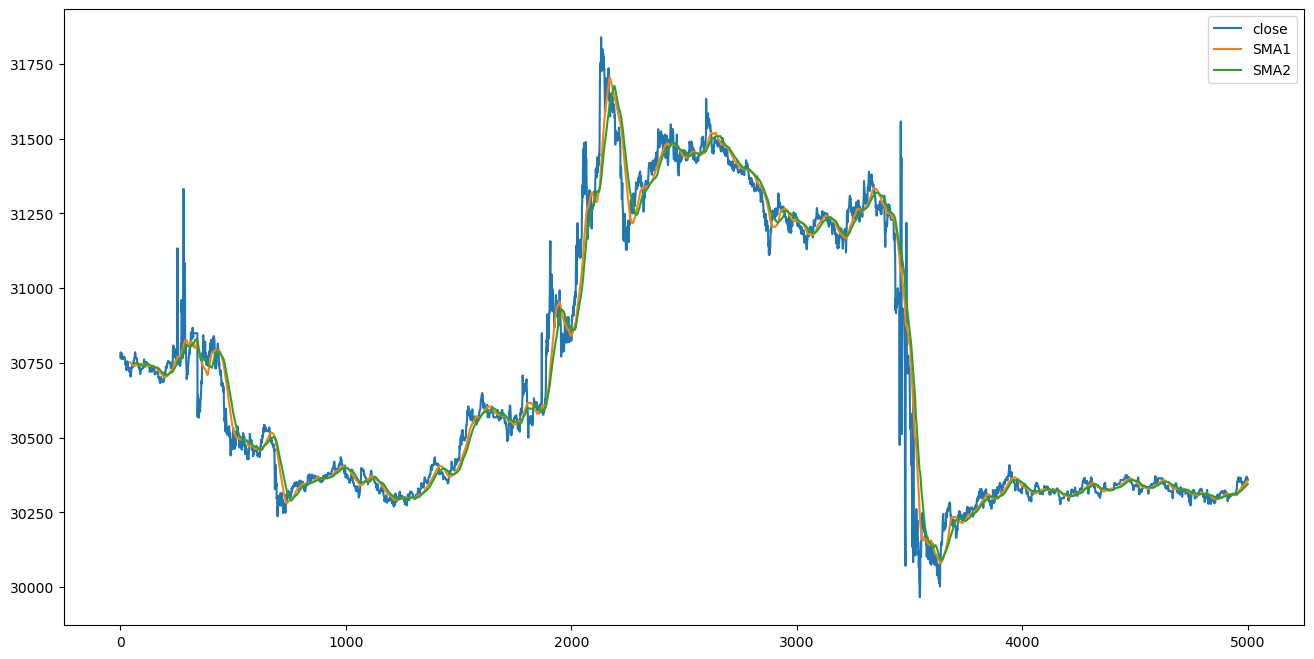

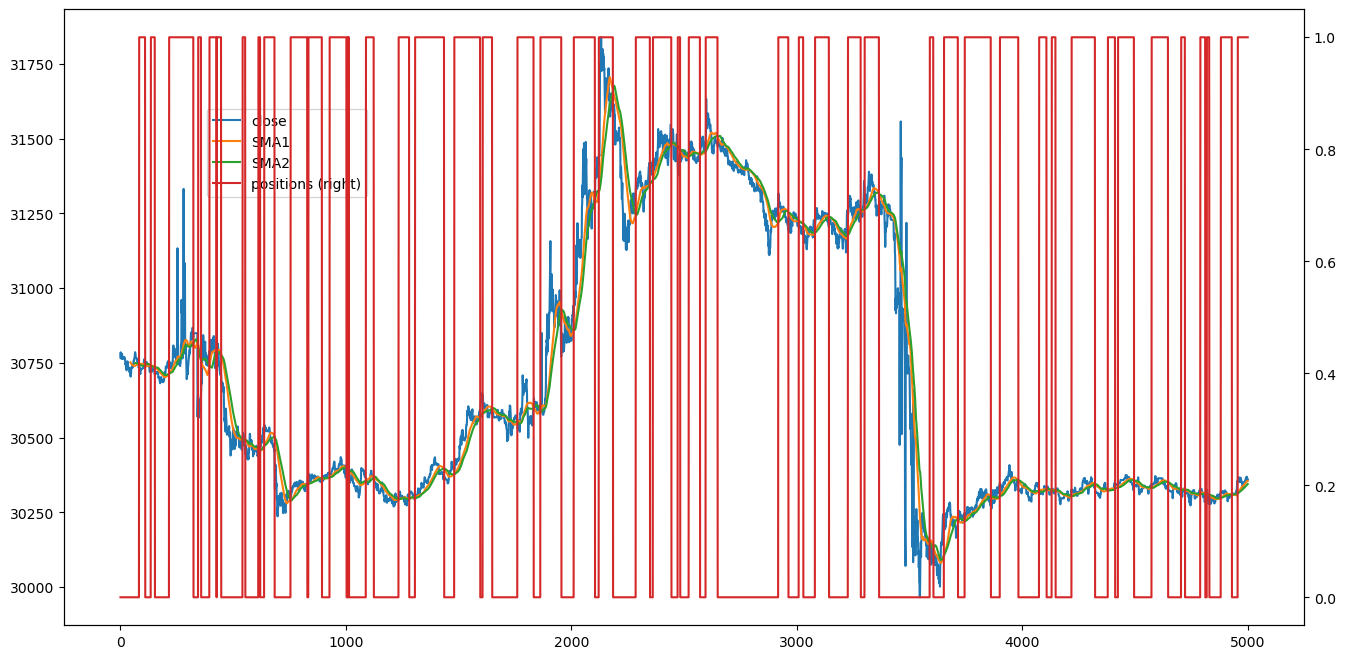

In [158]:
# Strategy
# Set the duration in seconds
duration = 22500 # 6hours 15 mins.
# Get the start time
position = True     # we assume that investor already positioned as LONG (already bought)
buy_amount(instrument_1, 10) # so let's take the position
start_time = time.time()
while time.time() - start_time < duration:
    
    dh = DataHandler(instrument_1)
    dh.download()
    data = dh.select('SELECT * FROM fi')

    # let's calculate the short-term and long-term SMA 
    data["SMA1"] = data["close"].rolling(frame["SMA1"][0]).mean()
    data["SMA2"] = data["close"].rolling(frame["SMA2"][0]).mean()

    delta = 0.017
    delta_trigger = 0.45
    P_0 = int(data["close"].values[-1]) #current_market_price
    P_1 = int(data["close"].values[-2]) #previous_market_price
    SMA1 = data["SMA1"][4999] #T'
    SMA1_1 = data["SMA1"][4998]
    SMA2 = data["SMA2"][4999] #T
    SMA2_2 = data["SMA2"][4998]
    print(f"P_0 = {P_0}")

    if P_0 < (1 - delta) * P_1:
        if position == True:
            # Sell
            print("Sell")
            sell_amount(instrument_1, 10)
            position = False
        else: # elif position == False:
            print("Position is already False, so hold the position (Cell 1)")
            pass
            # already False -- stay
    elif P_0 > (1 + delta) * P_1:
        if position == True:
            print("Buy more!")
            buy_amount(instrument_1, 10)
        else: # elif position == False:
            print("Buy")
            buy_amount(instrument_1, 10)
            position = True

    elif SMA1_1 < SMA2_2:
        if SMA1 > SMA2:
            if position == True:
                # already True -- stay
                print("Position is already True, so hold the position (Cell 3)")
                pass # stay
            else: # elif position == False:
                # BUY 
                print("establish long position (BUY)")
                buy_amount(instrument_1, 10)
                position = True

    elif SMA1_1 > SMA2_2:
        if SMA1 < SMA2:
            if position == True:
                # Sell
                sell_amount(instrument_1, 10)
                print("establish SHORT position (SELL)")
                position = False
            else: # elif position == False:
                # already False -- stay
                print("Position is already False, so hold the position  (Cell 4)")
                pass

    print(f"current position is {position}")
    trading = pd.DataFrame(actions)


    # The idea is that the trader should go long on a financial instrument in general (stock) when the short term SMA is above the longer SMA
    # and should go short when the opposite holds true.
        # Adding a delay to control the execution interval (e.g., every 20 seconds)
    time.sleep(20)
print("this code executed successfully.")
data[["close", "timestamp","SMA1", "SMA2"]].plot(figsize=(16,8))
data["positions"] = np.where(data["SMA1"] > data["SMA2"], 1, 0)
ax = data[["close", "SMA1", "SMA2", "positions"]].plot(figsize = (16,8),
                                                 secondary_y = "positions")
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))
display(data.tail())
display(trading)


Text(0.5, 1.0, 'NAV over Time')

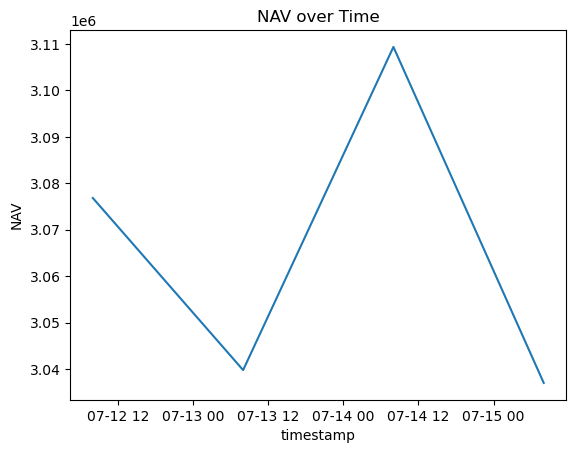

In [160]:
settlement()